<a href="https://colab.research.google.com/github/DarkAntiMage/LungsSound_Classification_SDA/blob/main/SDA_RelU_arsitek_high.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/gdrive')
import pandas as pd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/data_label.csv', dtype=str)
df['Nama File']=df['Nama File']+'.png'
df.head()

,index,id,file,StartRC,EndRC,Crackles,Whezze,class,FaseRes,Nama File
0,0,1,101,0.036,1.907,0,0,0,1,file101chunk0.png
1,1,2,101,1.907,4.521,0,0,0,0,file101chunk1.png
2,2,3,101,4.521,7.193,0,0,0,1,file101chunk2.png
3,3,4,101,7.193,9.75,0,0,0,0,file101chunk3.png
4,4,5,101,9.75,12.407,0,0,0,1,file101chunk4.png


In [ ]:
df_for_model = df[["Nama File","class"]].astype("str")
df_for_model.head()

,Nama File,class
0,file101chunk0.png,0
1,file101chunk1.png,0
2,file101chunk2.png,0
3,file101chunk3.png,0
4,file101chunk4.png,0


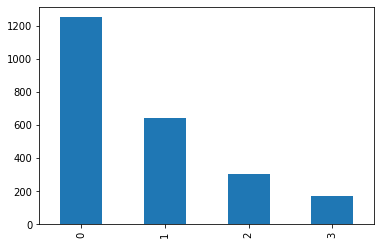

In [ ]:
df_for_model['class'].value_counts().plot.bar()

In [ ]:
from sklearn.model_selection import train_test_split
train_validate_df, final_test_df = train_test_split(df_for_model, test_size=0.15, stratify = df_for_model['class'].values, random_state=42)

train_validate_df = train_validate_df.reset_index(drop=True)
test_df = final_test_df.reset_index(drop=True)

In [ ]:
train_validate_df = pd.read_csv('/content/gdrive/My Drive/file TA excel/trainval.csv', dtype=str)
test_df = pd.read_csv('/content/gdrive/My Drive/file TA excel/test.csv', dtype=str)

In [ ]:
import random
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
#model 1
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf
input_img = Input(shape=(250, 250, 3))  # adapt this if using `channels_first` image data format


def sdae(inputimg):
  #autoencoder
  x = Conv2D(512, (3, 3), activation='relu', padding='same')(input_img)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  encoded = MaxPooling2D((2, 2), padding='same')(x)


  x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(512, (3, 3), activation='relu')(x)
  x = UpSampling2D((2, 2))(x)
  decode = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

  flat = Flatten()(decode)
  den = Dense(256, activation='relu')(flat)
  den = Dropout(0.5)(den)
  den = Dense(128, activation='relu')(den)
  out = Dense(4, activation='softmax')(den)

  return out

def callbacks(checkpoint_filepath):
  lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                       factor=0.1,
                                       patience=2,
                                       verbose=1,
                                       min_lr=0.000001)
  best_model_cekpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                              save_weights_only=True,
                                                              monitor='val_loss',
                                                              mode='max',
                                                              save_best_only=True)
  return [lr_reduction, best_model_cekpoint]

In [ ]:
checkpoint_filepath = '/content/gdrive/My Drive/autoencoder.h5'

In [ ]:
device_name = tf.test.gpu_device_name()
print('GPU at: {}'.format(device_name))

GPU at: /device:GPU:0


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
import glob
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.10, random_state=42)
X = train_validate_df["Nama File"].values  
y = train_validate_df["class"].values
i = 1
with tf.device('device:GPU:0'):
  for train_index, test_index in sss.split(X, y):
    print(f"***   StratifiedShuffleSplit {i}   ***")
    i+=1
    TrainVal_dict = {"Nama File": X[train_index],"class":y[train_index]}
    
    TrainVal_df = pd.DataFrame(TrainVal_dict)
    Train_df, Valid_df = train_test_split(TrainVal_df, test_size=0.10, stratify = TrainVal_df['class'].values, random_state=42)
    Train_df = Train_df.reset_index(drop=True)
    df_tr_nonaug = Train_df.copy()
    df_tr_pitchshift = Train_df.copy()
    df_tr_timestrech = Train_df.copy()
    df_tr_timestrech1 = Train_df.copy()
    df_tr_timestrech1 = Train_df.copy()
    
    df_tr_nonaug['path'] = 'none'
    files = glob.glob('/content/gdrive/My Drive/wavelet_denoising/*.png')
    for j in range(len(df_tr_nonaug)):
      if '/content/gdrive/My Drive/wavelet_denoising/'+str(df_tr_nonaug['Nama File'].iloc[j]) in files:
        df_tr_nonaug['path'].iloc[j] = '/content/gdrive/My Drive/wavelet_denoising/'+str(df_tr_nonaug['Nama File'].iloc[j])

    df_tr_pitchshift['path'] = 'none'
    files = glob.glob('/content/gdrive/My Drive/wavelet_pitchshifting_denoising/*.png')
    for k in range(len(df_tr_pitchshift)):
      if '/content/gdrive/My Drive/wavelet_pitchshifting_denoising/'+str(df_tr_timestrech['Nama File'].iloc[k]) in files:
        df_tr_pitchshift['path'].iloc[k] = '/content/gdrive/My Drive/wavelet_pitchshifting_denoising/'+str(df_tr_pitchshift['Nama File'].iloc[k])

    df_tr_timestrech['path'] = 'none'
    files = glob.glob('/content/gdrive/My Drive/wavelet_timestreching16_denoising/*.png')
    for l in range(len(df_tr_timestrech)):
      if '/content/gdrive/My Drive/wavelet_timestreching16_denoising/'+str(df_tr_timestrech['Nama File'].iloc[l]) in files:
        df_tr_timestrech['path'].iloc[l] = '/content/gdrive/My Drive/wavelet_timestreching16_denoising/'+str(df_tr_timestrech['Nama File'].iloc[l])

    df_tr_timestrech1['path'] = 'none'
    files = glob.glob('/content/gdrive/My Drive/wavelet_timestreching04_denoising/*.png')
    for m in range(len(df_tr_timestrech1)):
      if '/content/gdrive/My Drive/wavelet_timestreching04_denoising/'+str(df_tr_timestrech1['Nama File'].iloc[m]) in files:
        df_tr_timestrech1['path'].iloc[m] = '/content/gdrive/My Drive/wavelet_timestreching04_denoising/'+str(df_tr_timestrech1['Nama File'].iloc[m])
  
    df_tr = df_tr_nonaug.append([df_tr_pitchshift,df_tr_timestrech,df_tr_timestrech1])
    df_tr.reset_index(drop=True)

    df_val = Valid_df.reset_index(drop=True)
    df_val['path'] = 'none'
    files = glob.glob('/content/gdrive/My Drive/wavelet_denoising/*.png')
    for m in range(len(df_val)):
      if '/content/gdrive/My Drive/wavelet_denoising/'+str(df_val['Nama File'].iloc[m]) in files:
        df_val['path'].iloc[m] = '/content/gdrive/My Drive/wavelet_denoising/'+str(df_val['Nama File'].iloc[m])

    Test_dict = {"Nama File": X[test_index],"class":y[test_index]}
    df_te = pd.DataFrame(Test_dict)
    df_te = df_te.reset_index(drop=True)
    df_te['path'] = 'none'
    files = glob.glob('/content/gdrive/My Drive/wavelet_denoising/*.png')
    for n in range(len(df_te)):
      if '/content/gdrive/My Drive/wavelet_denoising/'+str(df_te['Nama File'].iloc[n]) in files:
        df_te['path'].iloc[n] = '/content/gdrive/My Drive/wavelet_denoising/'+str(df_te['Nama File'].iloc[n])


    train_generator = train_datagen.flow_from_dataframe(df_tr, x_col='path', y_col='class', target_size=(252,252),
                                                      class_mode='categorical', batch_size=16)

    val_generator = val_datagen.flow_from_dataframe(df_val, x_col='path', y_col='class', target_size=(252,252),
                                                      class_mode='categorical', batch_size=16)

    test_generator = test_datagen.flow_from_dataframe(df_te, x_col='path', y_col='class', target_size=(252,252),
                                                      class_mode='categorical', batch_size=16)
    
    Stacked_Denoising_Autoencode = Model(input_img, sdae(input_img))
    Stacked_Denoising_Autoencode.compile(optimizer= tf.keras.optimizers.RMSprop(learning_rate=0.00005) , loss='categorical_crossentropy', metrics=['accuracy'])
    
    train_model = Stacked_Denoising_Autoencode.fit(train_generator,
                    epochs=15,
                    steps_per_epoch= df_tr.shape[0]//16,
                    validation_steps= df_val.shape[0]//16,
                    validation_data=val_generator,
                    callbacks=callbacks(checkpoint_filepath))

    test_loss, test_acc = Stacked_Denoising_Autoencode.evaluate(test_generator)

    print(f'\nTest accuracy: {test_acc} \t Test loss: {test_loss}\n\n')    

***   StratifiedShuffleSplit 1   ***
Found 6516 validated image filenames belonging to 4 classes.
Found 182 validated image filenames belonging to 4 classes.
Found 202 validated image filenames belonging to 4 classes.
Epoch 1/15
407/407 [==============================] - 96s 236ms/step - loss: 1.1985 - accuracy: 0.5132 - val_loss: 1.1612 - val_accuracy: 0.5227 - lr: 5.0000e-05
Epoch 2/15
407/407 [==============================] - 95s 234ms/step - loss: 1.1633 - accuracy: 0.5238 - val_loss: 1.1468 - val_accuracy: 0.5227 - lr: 5.0000e-05
Epoch 3/15
407/407 [==============================] - 95s 234ms/step - loss: 1.1488 - accuracy: 0.5269 - val_loss: 1.1340 - val_accuracy: 0.5341 - lr: 5.0000e-05
Epoch 4/15
407/407 [==============================] - 95s 234ms/step - loss: 1.1367 - accuracy: 0.5340 - val_loss: 1.0808 - val_accuracy: 0.5341 - lr: 5.0000e-05
Epoch 5/15
407/407 [==============================] - 95s 234ms/step - loss: 1.1207 - accuracy: 0.5463 - val_loss: 1.0245 - val_accura

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
final_train_df, final_val_df = train_test_split(train_validate_df, test_size=0.15, stratify = train_validate_df['class'].values, random_state=42)

df_tr = final_train_df.reset_index(drop=True)
df_val = final_val_df.reset_index(drop=True)
df_te = test_df

In [ ]:
df_tr_nonaug = df_tr.copy()
df_tr_pitchshift = df_tr.copy()
df_tr_timestrech = df_tr.copy()
df_tr_timestrech1 = df_tr.copy()

In [ ]:
import glob
df_tr_nonaug['path'] = 'none'
files = glob.glob('/content/gdrive/My Drive/wavelet_denoising/*.png')
for i in range(len(df_tr_nonaug)):
  if '/content/gdrive/My Drive/wavelet_denoising/'+str(df_tr_nonaug['Nama File'].iloc[i]) in files:
    df_tr_nonaug['path'].iloc[i] = '/content/gdrive/My Drive/wavelet_denoising/'+str(df_tr_nonaug['Nama File'].iloc[i])

df_tr_pitchshift['path'] = 'none'
files = glob.glob('/content/gdrive/My Drive/wavelet_pitchshifting_denoising/*.png')
for i in range(len(df_tr_pitchshift)):
  if '/content/gdrive/My Drive/wavelet_pitchshifting_denoising/'+str(df_tr_timestrech['Nama File'].iloc[i]) in files:
    df_tr_pitchshift['path'].iloc[i] = '/content/gdrive/My Drive/wavelet_pitchshifting_denoising/'+str(df_tr_pitchshift['Nama File'].iloc[i])

df_tr_timestrech['path'] = 'none'
files = glob.glob('/content/gdrive/My Drive/wavelet_timestreching16_denoising/*.png')
for i in range(len(df_tr_timestrech)):
  if '/content/gdrive/My Drive/wavelet_timestreching16_denoising/'+str(df_tr_timestrech['Nama File'].iloc[i]) in files:
    df_tr_timestrech['path'].iloc[i] = '/content/gdrive/My Drive/wavelet_timestreching16_denoising/'+str(df_tr_timestrech['Nama File'].iloc[i])

df_tr_timestrech1['path'] = 'none'
files = glob.glob('/content/gdrive/My Drive/wavelet_timestreching04_denoising/*.png')
for i in range(len(df_tr_timestrech1)):
  if '/content/gdrive/My Drive/wavelet_timestreching04_denoising/'+str(df_tr_timestrech1['Nama File'].iloc[i]) in files:
    df_tr_timestrech1['path'].iloc[i] = '/content/gdrive/My Drive/wavelet_timestreching04_denoising/'+str(df_tr_timestrech1['Nama File'].iloc[i])

In [ ]:
df_tr = df_tr_nonaug.append([df_tr_pitchshift,df_tr_timestrech,df_tr_timestrech1])
df_tr.reset_index(drop=True)

,Nama File,class,path
0,file326chunk5.png,2,/content/gdrive/My Drive/wavelet_denoising/fil...
1,file333chunk2.png,0,/content/gdrive/My Drive/wavelet_denoising/fil...
2,file227chunk5.png,0,/content/gdrive/My Drive/wavelet_denoising/fil...
3,file372chunk0.png,0,/content/gdrive/My Drive/wavelet_denoising/fil...
4,file268chunk4.png,0,/content/gdrive/My Drive/wavelet_denoising/fil...
...,...,...,...
6839,file103chunk4.png,0,/content/gdrive/My Drive/wavelet_timestreching...
6840,file316chunk1.png,3,/content/gdrive/My Drive/wavelet_timestreching...
6841,file306chunk5.png,0,/content/gdrive/My Drive/wavelet_timestreching...
6842,file333chunk1.png,0,/content/gdrive/My Drive/wavelet_timestreching...


In [ ]:
df_te['path'] = 'none'
files = glob.glob('/content/gdrive/My Drive/wavelet_denoising/*.png')
for i in range(len(df_te)):
  if '/content/gdrive/My Drive/wavelet_denoising/'+str(df_te['Nama File'].iloc[i]) in files:
    df_te['path'].iloc[i] = '/content/gdrive/My Drive/wavelet_denoising/'+str(df_te['Nama File'].iloc[i])

In [ ]:
df_val['path'] = 'none'
files = glob.glob('/content/gdrive/My Drive/wavelet_denoising/*.png')
for i in range(len(df_val)):
  if '/content/gdrive/My Drive/wavelet_denoising/'+str(df_val['Nama File'].iloc[i]) in files:
    df_val['path'].iloc[i] = '/content/gdrive/My Drive/wavelet_denoising/'+str(df_val['Nama File'].iloc[i])

In [ ]:
print('train size', len(df_tr))
print('val size', len(df_val))
print('test size', len(df_te))

train size 6844
val size 302
test size 356


In [ ]:
train_generator = train_datagen.flow_from_dataframe(df_tr, x_col='path', y_col='class', target_size=(252,252),
                                                    class_mode='categorical', batch_size=16,)

val_generator = val_datagen.flow_from_dataframe(df_val, x_col='path', y_col='class', target_size=(252,252),
                                                    class_mode='categorical', batch_size=16)

test_generator = test_datagen.flow_from_dataframe(df_te, x_col='path', y_col='class', target_size=(252,252),
                                                    class_mode='categorical', batch_size=16)

Found 6844 validated image filenames belonging to 4 classes.
Found 302 validated image filenames belonging to 4 classes.
Found 356 validated image filenames belonging to 4 classes.


In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf

In [ ]:
with tf.device('device:GPU:0'):
  Stacked_Denoising_Autoencode = Model(input_img, sdae(input_img))
  Stacked_Denoising_Autoencode.compile(optimizer= tf.keras.optimizers.RMSprop(learning_rate=0.00005) , loss='categorical_crossentropy', metrics=['accuracy'])
    
  train_model = Stacked_Denoising_Autoencode.fit(train_generator,
                  epochs=40,
                  steps_per_epoch= df_tr.shape[0]//16,
                  validation_steps= df_val.shape[0]//16,
                  validation_data=val_generator,
                  callbacks=callbacks(checkpoint_filepath))

Epoch 1/40
427/427 [==============================] - 102s 240ms/step - loss: 1.1973 - accuracy: 0.5230 - val_loss: 1.1520 - val_accuracy: 0.5208 - lr: 5.0000e-05
Epoch 2/40
427/427 [==============================] - 100s 235ms/step - loss: 1.1525 - accuracy: 0.5264 - val_loss: 1.1330 - val_accuracy: 0.5347 - lr: 5.0000e-05
Epoch 3/40
427/427 [==============================] - 100s 235ms/step - loss: 1.1439 - accuracy: 0.5308 - val_loss: 1.1264 - val_accuracy: 0.5486 - lr: 5.0000e-05
Epoch 4/40
427/427 [==============================] - 101s 235ms/step - loss: 1.1140 - accuracy: 0.5453 - val_loss: 1.0810 - val_accuracy: 0.5451 - lr: 5.0000e-05
Epoch 5/40
427/427 [==============================] - 100s 235ms/step - loss: 1.0822 - accuracy: 0.5551 - val_loss: 1.0786 - val_accuracy: 0.5660 - lr: 5.0000e-05
Epoch 6/40
427/427 [==============================] - 100s 235ms/step - loss: 1.0595 - accuracy: 0.5633 - val_loss: 1.0659 - val_accuracy: 0.5347 - lr: 5.0000e-05
Epoch 7/40
427/427 [==

In [ ]:
Stacked_Denoising_Autoencode.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250, 250, 3)]     0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 250, 250, 512)     14336     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 125, 125, 512)     0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 125, 125, 256)     1179904   
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 63, 63, 256)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 63, 63, 128)       295040    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 32, 32, 128)       0   

In [ ]:
test_loss, test_acc = Stacked_Denoising_Autoencode.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc} \t Test loss: {test_loss}\n\n')

23/23 [==============================] - 2s 83ms/step - loss: 0.8832 - accuracy: 0.6798

Test accuracy: 0.6797752976417542 	 Test loss: 0.8831642270088196




In [ ]:
# Save Model
# Save the weights
Stacked_Denoising_Autoencode.save_weights('/content/gdrive/My Drive/lung sound classification RelU High arsi.h5')

# Save the model architecture
with open('Lung_Classification_model_architecture Tanh High arsi.json', 'w') as f:
    f.write(Stacked_Denoising_Autoencode.to_json())

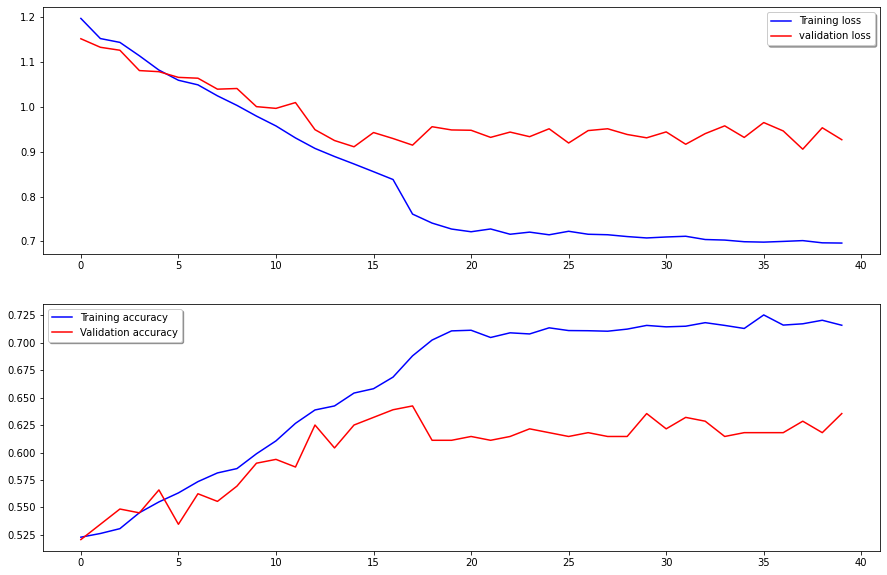

In [ ]:
# Virtualize Training
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,1)
plt.gcf().set_size_inches(15, 10)
ax[0].plot(train_model.history['loss'], color='b', label="Training loss")
ax[0].plot(train_model.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(train_model.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(train_model.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
predict = Stacked_Denoising_Autoencode.predict(test_generator, verbose=2)

23/23 - 2s


In [ ]:
(test_generator.class_indices)

{'0': 0, '1': 1, '2': 2, '3': 3}

In [ ]:
predict_dec = predict.argmax(axis=-1)
predict_dec = list(map(str,predict_dec))

In [ ]:
from sklearn.metrics import log_loss, confusion_matrix, classification_report
conf_mat = confusion_matrix(df_te["class"].values, predict_dec)
conf_mat

array([[116,  52,  12,   8],
       [ 53,  27,   9,   7],
       [ 29,  12,   3,   2],
       [ 16,   4,   2,   4]])

In [ ]:
print(classification_report(df_te["class"].values, predict_dec, target_names=["Normal","Crackle","Wheeze","Crackle and Wheeze"]))

                    precision    recall  f1-score   support

            Normal       0.54      0.62      0.58       188
           Crackle       0.28      0.28      0.28        96
            Wheeze       0.12      0.07      0.08        46
Crackle and Wheeze       0.19      0.15      0.17        26

          accuracy                           0.42       356
         macro avg       0.28      0.28      0.28       356
      weighted avg       0.39      0.42      0.40       356

